# Classify anime characters with a fine-tuned model
(This notebook is based on [mitmul/chainer-handson/animeface-character/classify_characters.ipynb](https://github.com/mitmul/chainer-handson/blob/master/animeface-character/classify_characters.ipynb) in Japanese.)

In this notebook, we will learn to:

1. Fine-tune an Illustration2Vec model on the "animeface-character" dataset.
2. Classify 146 kinds of character faces with more than 90% accuracy using the fine-tuned models.

After reading the notebook, using Chainer you should be able to:

- Make a new dataset object.
- Divide a dataset into training / validation.
- Fine-tune a model on a new task by using a trained models.
- Bonus: How to write a dataset class from scratch.

### Summary

We show a specific example of  **how to setup a dataset which is not already provided by Chainer** and use it for training a network. The basic procedure is almost the same as the chapter that explains the CIFAR 10 dataset class (described in [Chainer v 4: Beginner Tutorial](https://qiita.com/mitmul/items/1e35fba085eb07a92560), Japanese only for now).

Here, we will explain **how to initialize models with weights of pre-trained models**.
The new model will be initialized with models whose domain is related to our current task. To fine-tune a network from Caffe's `.caffemodel`, the procedure is the same.

First, we execute the following cell and install “Chainer” and its GPU back end “CuPy”. If the “runtime type” of Colaboratory is GPU, you can run Chainer with GPU as a backend.

In [1]:
!curl https://colab.chainer.org/install | sh -

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libcusparse8.0 is already the newest version (8.0.61-1).
libnvrtc8.0 is already the newest version (8.0.61-1).
libnvtoolsext1 is already the newest version (8.0.61-1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


Let’s import the necessary modules, then check the version of Chainer, NumPy, CuPy, Cuda and other execution environments.

In [2]:
import chainer

chainer.print_runtime_info()

Chainer: 4.4.0
NumPy: 1.14.5
CuPy:
  CuPy Version          : 4.4.0
  CUDA Root             : None
  CUDA Build Version    : 8000
  CUDA Driver Version   : 9000
  CUDA Runtime Version  : 8000
  cuDNN Build Version   : 7102
  cuDNN Version         : 7102
  NCCL Build Version    : 2213


Use `pip` to install the required libraries.

In [3]:
%%bash
pip install Pillow
pip install dill

  Running setup.py bdist_wheel for dill: started
  Running setup.py bdist_wheel for dill: finished with status 'done'
  Stored in directory: /root/.cache/pip/wheels/e2/5d/17/f87cb7751896ac629b435a8696f83ee75b11029f5d6f6bda72
Successfully built dill


## 1. Download the dataset

First, we will download the dataset, we will use [this dataset](http://www.nurs.or.jp/~nagadomi/animeface-character-dataset/). Credits to `@nagadomi` (a Kaggle Grand Master), who created the face area thumbnails from animated character.

In [4]:
%%bash
if [ ! -d animeface-character-dataset ]; then
    curl -L -O http://www.nurs.or.jp/~nagadomi/animeface-character-dataset/data/animeface-character-dataset.zip
    unzip -q animeface-character-dataset.zip
    rm -rf animeface-character-dataset.zip
fi

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  564M  100  564M    0     0  56.4M      0  0:00:10  0:00:10 --:--:-- 56.4M


## 2. Problem settings

We use images of anime character faces in "animeface-character-dataset", and train a network
to classify which character is in the image.
We classify the character faces in the validation dataset, because we separate training and the validation dataset.

Also, **we initialize the model weights using a pre-trained model from a similar domain, rather than randomly initializing the weights.** We don't train our model from scratch, this is commonly known as **fine-tuning**.

The dataset used for training contains many images, with each characters in its own folder.
### Example images

- 000_hatsune_miku

![face_128_326_108.png](https://qiita-image-store.s3.amazonaws.com/0/17934/4c7e3f61-b930-581c-b481-58dd724889d9.png)

- 002_suzumiya_haruhi

![face_1000_266_119.png](https://qiita-image-store.s3.amazonaws.com/0/17934/ddac8de1-96b3-3b25-e9ec-6f0b7869e89a.png)

- 007_nagato_yuki

![face_83_270_92.png](https://qiita-image-store.s3.amazonaws.com/0/17934/d1fc7844-8e4d-073b-f4a0-b921fdcc9061.png)

- 012_asahina_mikuru

![face_121_433_128.png](https://qiita-image-store.s3.amazonaws.com/0/17934/8d932513-de0e-547f-a118-828f378e4885.png)

## 3. Creating a dataset object

Here, we show how to create a dataset object using a class called `LabeledImageDataset` which is often used for image classification problems.

First, we will get the path list of the image files. The image files are located in the different directories for each character under `animeface-character-dataset/thumb` directory.  In the code below, if the file `ignore` is contained in the directory, we will skip that directory to load.

In [0]:
import os
import glob
from itertools import chain

# image directories
IMG_DIR = 'animeface-character-dataset/thumb'

# directories for each character
dnames = glob.glob('{}/*'.format(IMG_DIR))

# the list of image files' path
fnames = [glob.glob('{}/*.png'.format(d)) for d in dnames
          if not os.path.exists('{}/ignore'.format(d))]
fnames = list(chain.from_iterable(fnames))

Next, because the name of image directories contains the name of the character, we use it to make an ID that makes it unique for each character.


In [0]:
# Create unique id for each character from the directory name
labels = [os.path.basename(os.path.dirname(fn)) for fn in fnames]
dnames = [os.path.basename(d) for d in dnames
          if not os.path.exists('{}/ignore'.format(d))]
labels = [dnames.index(l) for l in labels]

Let's create a simple dataset object. We simply pass the list of tuples with the file path and its label to `LabeledImageDataset`. This is an iterator that returns a tuple like `(img, label)`.

In [0]:
from chainer.datasets import LabeledImageDataset

# Crate dataset
d = LabeledImageDataset(list(zip(fnames, labels)))

Next, we use a convenient function called `TransformDataset` provided by Chainer. This is a wrapper class that takes dataset objects and functions that represent the transformation to each data, which you can use to prepare the data augmentation and preprocessing parts outside the dataset class.

In [0]:
from chainer.datasets import TransformDataset
from PIL import Image

width, height = 160, 160

# function for resizing images
def resize(img):
    img = Image.fromarray(img.transpose(1, 2, 0))
    img = img.resize((width, height), Image.BICUBIC)
    return np.asarray(img).transpose(2, 0, 1)

# transformation for each data
def transform(inputs):
    img, label = inputs
    img = img[:3, ...]
    img = resize(img.astype(np.uint8))
    img = img - mean[:, None, None]
    img = img.astype(np.float32)
    # Flip horizontally at random
    if np.random.rand() > 0.5:
        img = img[..., ::-1]
    return img, label

# dataset with transformation
td = TransformDataset(d, transform)

By doing this, you can create a dataset object that returns the dataset transformed by `transform` function.

Let's split this into two separeted datasets for training and velidation. We use 80% of the entire dataset for traiing, and the remaining 20% for validation. `split_dataset_random` shuffles the data in the dataset once, and then split it.

In [0]:
from chainer import datasets

train, valid = datasets.split_dataset_random(td, int(len(d) * 0.8), seed=0)

Several other functions are also provided, such as `get_cross_validation_datasets_random` which returns several different pairs of training and verification data sets for cross validation. Have a look at this.：[SubDataset](https://docs.chainer.org/en/stable/reference/datasets.html#subdataset)

Then, `mean` used in `transform` is the average image contained in the training dataset. Let's calculate this.

In [0]:
import matplotlib.pyplot as plt
import numpy as np


# if the average image is not calculated, just calculate it
if not os.path.exists('image_mean.npy'):
    # We want to calculate the average without transformation
    t, _ = datasets.split_dataset_random(d, int(len(d) * 0.8), seed=0)

    mean = np.zeros((3, height, width))
    for img, _ in t:
        img = resize(img[:3].astype(np.uint8))
        mean += img
    mean = mean / float(len(d))
    np.save('image_mean', mean)
else:
    mean = np.load('image_mean.npy')

Let's display the calculated average image.

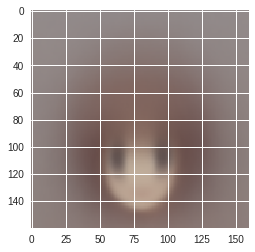

In [11]:
# diplay averaged image
%matplotlib inline
plt.imshow(mean.transpose(1, 2, 0) / 255)
plt.show()

You may be scared with the image...

When subtracting the mean from each image, we use the average for each pixel. So, we calculate the average pixel value (RGB) of this average image.

In [0]:
mean = mean.mean(axis=(1, 2))

## 4. Model definition and preparation for Fine-tuning

Next, we will define the model. Here, we define the new model based on the network used in [Illustration2Vec](https://github.com/rezoo/illustration2vec), whch can predict tag, extract features and etc.
The new model use the layers of Illustration2Vec except last two layers, and add two fully-connected layers instead of them. The two fully-connected layers are initialized randomly.

When traiing, we fix the weights of the Illustration2Vec layers. It means that **we only train two newly added layers**.

First, I download the trained parameters of the Illustration2Vec model.

In [13]:
%%bash
if [ ! -f illust2vec_ver200.caffemodel ]; then
    curl -L -O https://github.com/rezoo/illustration2vec/releases/download/v2.0.0/illust2vec_ver200.caffemodel
fi

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   618    0   618    0     0    618      0 --:--:-- --:--:-- --:--:--  2771
100  933M  100  933M    0     0  35.8M      0  0:00:26  0:00:26 --:--:-- 86.4M


This trained weights are provided in the form of caffemodel, and Chainer is very easy to load Caffe's trained model ([`CaffeFunction`](http://docs.chainer.org/en/stable/reference/generated/chainer.links.caffe.CaffeFunction.html#chainer.links.caffe.CaffeFunction)). So, we use this to load the parameters and model structure. However, since it takes time to load, we save the `Chain` object using Python standard module ` pickle`. By doing this, loading model becomes faster next time .

The actual network code is as follows.

In [14]:
import dill

import chainer
import chainer.links as L
import chainer.functions as F

from chainer import Chain
from chainer.links.caffe import CaffeFunction
from chainer import serializers


class Illust2Vec(Chain):

    CAFFEMODEL_FN = 'illust2vec_ver200.caffemodel'

    def __init__(self, n_classes, unchain=True):
        w = chainer.initializers.HeNormal()        
        model = CaffeFunction(self.CAFFEMODEL_FN)  # Load and save CaffeModel. (It takes time)
        del model.encode1  # Delete unnecessary layers for memory saving.。
        del model.encode2
        del model.forwards['encode1']
        del model.forwards['encode2']
        model.layers = model.layers[:-2]
        
        super(Illust2Vec, self).__init__()
        with self.init_scope():
            self.trunk = model  # Include the original Illust2Vec model as trunk in this model.
            self.fc7 = L.Linear(None, 4096, initialW=w)
            self.bn7 = L.BatchNormalization(4096)
            self.fc8 = L.Linear(4096, n_classes, initialW=w)
            
    def __call__(self, x):
        h = self.trunk({'data': x}, ['conv6_3'])[0]  # Extract the output of conv6_3 of the original Illust2Vec model.
        h.unchain_backward()
        h = F.dropout(F.relu(self.bn7(self.fc7(h))))  # Here and after are newly added layers
        return self.fc8(h)


n_classes = len(dnames)
model = Illust2Vec(n_classes)
model = L.Classifier(model)

/usr/local/lib/python3.6/dist-packages/chainer/links/caffe/caffe_function.py:165: UserWarning: Skip the layer "encode1neuron", since CaffeFunction does notsupport Sigmoid layer
  'support %s layer' % (layer.name, layer.type))
/usr/local/lib/python3.6/dist-packages/chainer/links/caffe/caffe_function.py:165: UserWarning: Skip the layer "loss", since CaffeFunction does notsupport SigmoidCrossEntropyLoss layer
  'support %s layer' % (layer.name, layer.type))


Look at `h.unchain_backward()` appeared in `__call__`.  If we call `unchain_backward` of some intermediate ` Variable` of the network,  it cuts off connection of forward node. Therefore, during training, no errors are transmitted to the forward layers. As a result, the parameter is not updated.

As I mentioned abeve,

> When traiing, we fix the weights of the Illustration2Vec layers. It means that **we only train two newly added layers**.

It can be achieved by `h.unchain_backward()`.

## 5. Learning

Let's train the model with the dataset. First, load the necessary modules.

In [0]:
from chainer import iterators
from chainer import training
from chainer import optimizers
from chainer.training import extensions
from chainer.training import triggers
from chainer.dataset import concat_examples

Next, set the training parameters as follows:

- Batch size : 64
- Learning rate starts at 0.01 and it is multiplied by 0.1 at 10 epochs.
- Learn with 20 epochs

In [0]:
batchsize = 64
gpu_id = 0
initial_lr = 0.01
lr_drop_epoch = 10
lr_drop_ratio = 0.1
train_epoch = 20

Let's kick the training.

In [17]:
train_iter = iterators.MultiprocessIterator(train, batchsize)
valid_iter = iterators.MultiprocessIterator(
    valid, batchsize, repeat=False, shuffle=False)

optimizer = optimizers.MomentumSGD(lr=initial_lr)
optimizer.setup(model)
optimizer.add_hook(chainer.optimizer.WeightDecay(0.0001))

updater = training.StandardUpdater(
    train_iter, optimizer, device=gpu_id)

trainer = training.Trainer(updater, (train_epoch, 'epoch'), out='AnimeFace-result')
trainer.extend(extensions.LogReport())
trainer.extend(extensions.observe_lr())

# logging values
trainer.extend(extensions.PrintReport(
    ['epoch',
     'main/loss',
     'main/accuracy',
     'val/main/loss',
     'val/main/accuracy',
     'elapsed_time',
     'lr']))

# Save loss plot automatically every epoch
trainer.extend(extensions.PlotReport(
        ['main/loss',
         'val/main/loss'],
        'epoch', file_name='loss.png'))

# Save accuracy plot automatically every epoch
trainer.extend(extensions.PlotReport(
        ['main/accuracy',
         'val/main/accuracy'],
        'epoch', file_name='accuracy.png'))

# Extension to validate model with train property set to False
trainer.extend(extensions.Evaluator(valid_iter, model, device=gpu_id), name='val')

# Learning rate is multiplied by lr_drop_ratio for each specified epoch
trainer.extend(
    extensions.ExponentialShift('lr', lr_drop_ratio),
    trigger=(lr_drop_epoch, 'epoch'))

trainer.run()

epoch       main/loss   main/accuracy  val/main/loss  val/main/accuracy  elapsed_time  lr        
1           1.60994     0.613411       0.6051         0.833812           102.794       0.01        
2           0.605895    0.828228       0.550095       0.860241           193.605       0.01        
3           0.407292    0.885969       0.469584       0.870144           284.337       0.01        
4           0.325062    0.905112       0.427613       0.887003           374.966       0.01        
5           0.250727    0.923531       0.396959       0.895822           465.039       0.01        
6           0.206382    0.938431       0.406959       0.890555           555.431       0.01        
7           0.184174    0.943398       0.385616       0.901281           645.739       0.01        
8           0.153923    0.955195       0.379971       0.90401            735.907       0.01        
9           0.136681    0.957574       0.384024       0.904159           826.123       0.01        
10

Training was finishued in about 30 minutes. The result of logging was like the above. Finally, we have achieved more than 90% accuracy with the validation dataset. Let's display the loss curve and the accuracy curve during the training process.

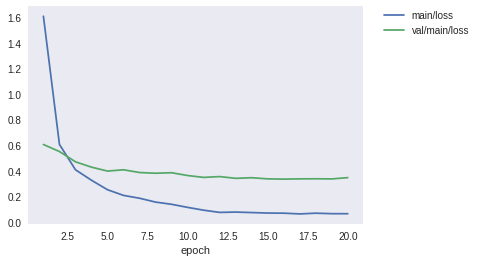

In [18]:
from IPython.display import Image
Image(filename='AnimeFace-result/loss.png')

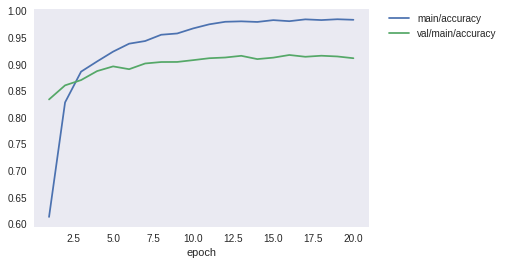

In [19]:
Image(filename='AnimeFace-result/accuracy.png')

It seems that it has successfully converged.

Finally, we take several images from validation datasets, and look at the individual classification results.

pred: 191_shidou_hikaru label: 191_shidou_hikaru True


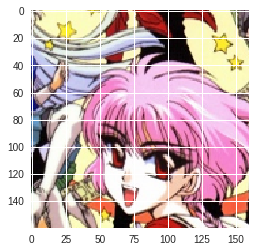

pred: 139_caro_ru_lushe label: 139_caro_ru_lushe True


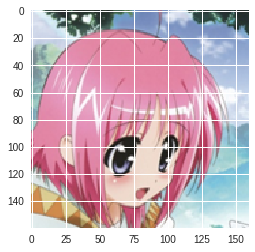

pred: 180_matsuoka_miu label: 180_matsuoka_miu True


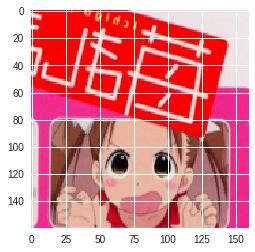

pred: 070_nijihara_ink label: 070_nijihara_ink True


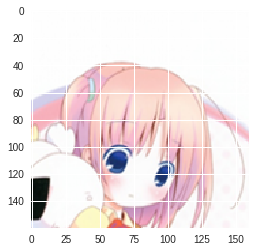

pred: 001_kinomoto_sakura label: 001_kinomoto_sakura True


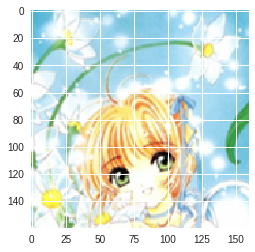

pred: 114_natsume_rin label: 114_natsume_rin True


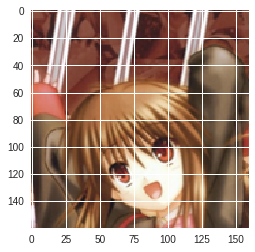

pred: 014_hiiragi_kagami label: 014_hiiragi_kagami True


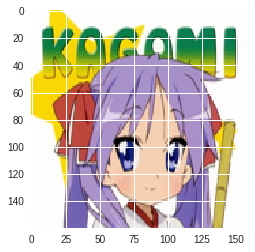

pred: 055_ibuki_fuuko label: 169_shihou_matsuri False


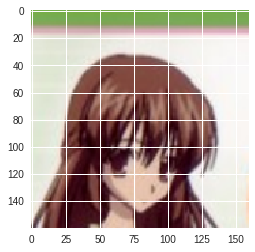

pred: 070_nijihara_ink label: 070_nijihara_ink True


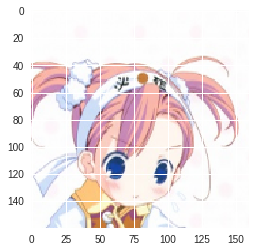

pred: 171_ikari_shinji label: 171_ikari_shinji True


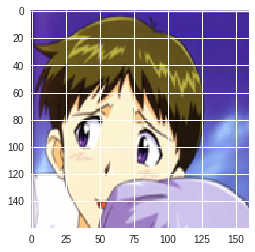

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

from PIL import Image
from chainer import cuda

chainer.config.train = False
for _ in range(10):
    x, t = valid[np.random.randint(len(valid))]
    x = cuda.to_gpu(x)
    y = F.softmax(model.predictor(x[None, ...]))
    
    pred = os.path.basename(dnames[int(y.data.argmax())])
    label = os.path.basename(dnames[t])
    
    print('pred:', pred, 'label:', label, pred == label)

    x = cuda.to_cpu(x)
    x += mean[:, None, None]
    x = x / 256
    x = np.clip(x, 0, 1)
    plt.imshow(x.transpose(1, 2, 0))
    plt.show()

When I randomly selected ten images, I got the 9 correct answers. How about you?

Finally, it may be usfull, we save the snapshot of the model.

In [0]:
from chainer import serializers

serializers.save_npz('animeface.model', model)

## 6. Extra 1: How to write dataset class in full scratch

To write a dataset class in full scratch, you have to prepare a self class that inherits the `chainer.dataset.DatasetMixin` class. That class must have `__len__` and` get_example` methods.
For example, it becomes as follows.

```python
class MyDataset(chainer.dataset.DatasetMixin):
    
    def __init__(self, image_paths, labels):
        self.image_paths = image_paths
        self.labels = labels
        
    def __len__(self):
        return len(self.image_paths)
    
    def get_example(self, i):
        img = Image.open(self.image_paths[i])
        img = np.asarray(img, dtype=np.float32)
        img = img.transpose(2, 0, 1)
        label = self.labels[i]
        return img, label
  ```

This class is instanciate with a list of image file paths and a list of labels arranged in a corresponding order.
If we specify an index with the `[]` accessor, it load the image from the corresponding path, aligne it with the label, and return them as a tuple.

For example, it can be used as follows.

```python
image_files = ['images/hoge_0_1.png', 'images/hoge_5_1.png', 'images/hoge_2_1.png', 'images/hoge_3_1.png', ...]
labels = [0, 5, 2, 3, ...]

dataset = MyDataset(image_files, labels)

img, label = dataset[2]

#=> it will return the image data and its label of 'images/hoge_2_1.png'.
```

This object can be passed directly to the Iterator and can be used for training using the Trainer. In other words,


```python
train_iter = iterators.MultiprocessIterator(dataset, batchsize=128)
```

we can create an iterator like this, pass it to the updater along with the Optimizer.

## 7. Extra 2: How to make the simplest dataset object

Actually, the dataset for Trainer is ** just a Python list**. In other words, if **you can get the length with `len()` and the element can be retrieved with the `[]` accessor**, you can treat it as a dataset object. For example,

```python
data_list = [(x1, t1), (x2, t2), ...]
```

If you make a list of tuples such as `(data, label)`, you can pass them to the Iterator.

```python
train_iter = iterators.MultiprocessIterator(data_list, batchsize=128)
```

However, the drawback of such a way is that you have to put the entire dataset in memory before training. In order to prevent this, the combination of [ImageDataset](http://docs.chainer.org/en/stable/reference/generated/chainer.datasets.ImageDataset.html#chainer.datasets.ImageDataset) and [TupleDataset](http://docs.chainer.org/en/stable/reference/generated/chainer.datasets.TupleDataset.html#chainer.datasets.TupleDataset), and [LabaledImageDataset](http://docs.chainer.org/en/stable/reference/generated/chainer.datasets.LabeledImageDataset.html#chainer.datasets.LabeledImageDataset) are provided. Please refer to the document for details.

http://docs.chainer.org/en/stable/reference/datasets.html#general-datasets